In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
from matplotlib import pyplot as plt
import tqdm as tqdm

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

In [32]:
### Cleaner but same as cell below.min
# go_envelope_tensor = torch.Tensor([condition['goEnvelope'] for all_delayed_conditions in conds_for_sim for condition in all_delayed_conditions])
# plan_tensor = torch.Tensor([condition['plan'] for all_delayed_conditions in conds_for_sim for condition in all_delayed_conditions])
# muscle_tensor = torch.Tensor([condition['muscle'][:,[4,5]] for all_delayed_conditions in conds_for_sim for condition in all_delayed_conditions])
# print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
# print(f"Plan Tensor Shape: {plan_tensor.shape}")
# print(f"Muscle Tensor Shape: {muscle_tensor.shape}")

# num_conditions = len(conds_for_sim)

Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [30]:
# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [4, 5]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [33]:
# Normalization and Standardization
def normalize_and_standardize(tensor):

    # Standardize: shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply normalization and standardization to go_envelope_tensor and plan_tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Concatenate normalized tensors along the last dimension
X_train = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)
y_train = normalized_muscle_tensor

batch_size = 256  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [59]:
# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))

        input_update = torch.matmul(self.B, x.transpose(0, 1))
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)

        # Output calculation
        output = self.output_linear(firing_rate)

        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum() 
        
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()

        return output, hidden, firing_rate_reg, dynamic_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg


Epoch 1, Loss: 1.631474494934082
Epoch 2, Loss: 1.2878026962280273
Epoch 3, Loss: 1.1542924642562866
Epoch 4, Loss: 1.091951847076416
Epoch 5, Loss: 1.0396171808242798
Epoch 6, Loss: 0.9931025505065918
Epoch 7, Loss: 0.9417989253997803
Epoch 8, Loss: 0.8847976326942444
Epoch 9, Loss: 0.8268141746520996
Epoch 10, Loss: 0.7745983004570007
Epoch 11, Loss: 0.7371586561203003
Epoch 12, Loss: 0.7027837038040161
Epoch 13, Loss: 0.6664097905158997
Epoch 14, Loss: 0.6318494081497192
Epoch 15, Loss: 0.5993249416351318
Epoch 16, Loss: 0.5746090412139893
Epoch 17, Loss: 0.5352203845977783
Epoch 18, Loss: 0.5097219944000244
Epoch 19, Loss: 0.5024834275245667
Epoch 20, Loss: 0.47264015674591064
Epoch 21, Loss: 0.4683624505996704
Epoch 22, Loss: 0.4382856488227844
Epoch 23, Loss: 0.43924400210380554
Epoch 24, Loss: 0.4152510166168213
Epoch 25, Loss: 0.428199827671051
Epoch 26, Loss: 0.408000648021698
Epoch 27, Loss: 0.39920419454574585
Epoch 28, Loss: 0.3936007022857666
Epoch 29, Loss: 0.380854547023

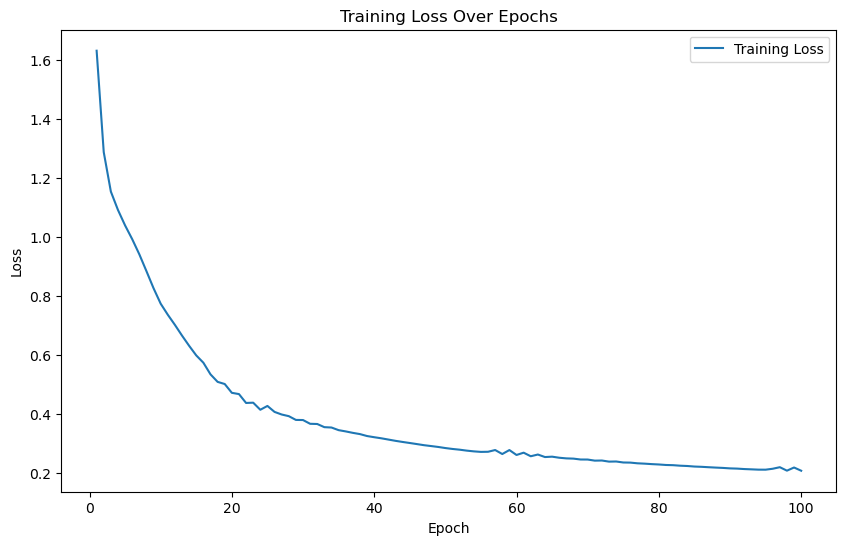

In [60]:

    
# Hyperparameters
input_size = 16
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 100
epoch_losses = [] 

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device) # Initialize hidden state with the current batch size
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        for t in range(inputs.shape[1]):  # Iterate over time steps
            output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
            hidden_states_for_plot.append(h.detach().cpu().numpy())
            total_firing_rate_reg += firing_rate_reg
            total_dynamic_reg += dynamic_reg

        
    
        # Compute loss using the last output and include regularization terms
        loss = criterion(output, targets[:, -1, :])
        l2_reg = compute_l2_regularization(model.parameters(), alpha)
        rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size /num_conditions  # Average over time steps
        rj_reg = gamma * total_firing_rate_reg / inputs.shape[1] /num_conditions # Average over time steps
    
        total_loss = loss + l2_reg + rfr_reg + rj_reg

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
        running_loss += total_loss.item()

    avg_loss = running_loss / float(len(train_loader))
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# After training, convert the list of hidden states to a NumPy array for easier manipulation
hidden_states_for_plot = np.array(hidden_states_for_plot)
print(hidden_states_for_plot.shape)

hidden_size = 300  # This should match the hidden size of your RNN

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
###  NEEDS UPDATING BASED ON CHANGES ABOVE ###



# class ComplicatedRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
#         super(ComplicatedRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.tau = tau  # Time constant

#         # Modified weight initialization for a more chaotic regime (g >> 1)
#         self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
#         self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
#         self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
#         self.bx = nn.Parameter(torch.zeros(hidden_size))
#         self.bz = nn.Parameter(torch.zeros(output_size))

#         # Nonlinearity remains the same
#         self.nonlinearity = torch.tanh
    
#     def forward(self, x, hidden):
#         timestep = self.tau / 10  # Timestep for Euler integration
#         for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
#             hidden_update = torch.matmul(self.J, hidden.T)
#             input_update = torch.matmul(self.B, x.T)
#             new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
#             new_hidden = new_hidden.T

#             # Euler integration for continuous-time update
#             hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
#         output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
#         output = output.T
    
#         return output, hidden

#     def init_hidden(self):
#         # Initialize hidden state with an additional batch dimension
#         return torch.zeros(1, self.hidden_size)

# input_size = 7
# hidden_size = 300
# output_size = 2 # Number of muscles
# g = 4 # Significantly larger g value for complicated model
# h = 1.0 # h value remains the same

# complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h)

In [ ]:
# # Training Loop
# num_epochs = 250  # The number of epochs
# epoch_losses = []  # To store average loss per epoch

# for epoch in range(num_epochs):
#     running_loss = 0.0

#     for inputs, targets in train_loader:
#         optimizer2.zero_grad()
#         batch_size = inputs.size(0)
#         h = complicated_model.init_hidden()  # Initialize hidden state

#         total_loss = 0.0  # Accumulate loss over time steps

#         for t in range(inputs.shape[1]):
#             output, h = complicated_model(inputs[:, t, :], h)
#             loss = criterion(output, targets[:, t, :])  # Compute loss at each time step
#             total_loss += loss

#         total_loss.backward()  # Backpropagation on the accumulated loss
#         optimizer2.step()

#         running_loss += total_loss.item()

#     avg_loss = running_loss / len(train_loader)
#     epoch_losses.append(avg_loss)
#     print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

# print('Finished Training')

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.legend()
# plt.show()


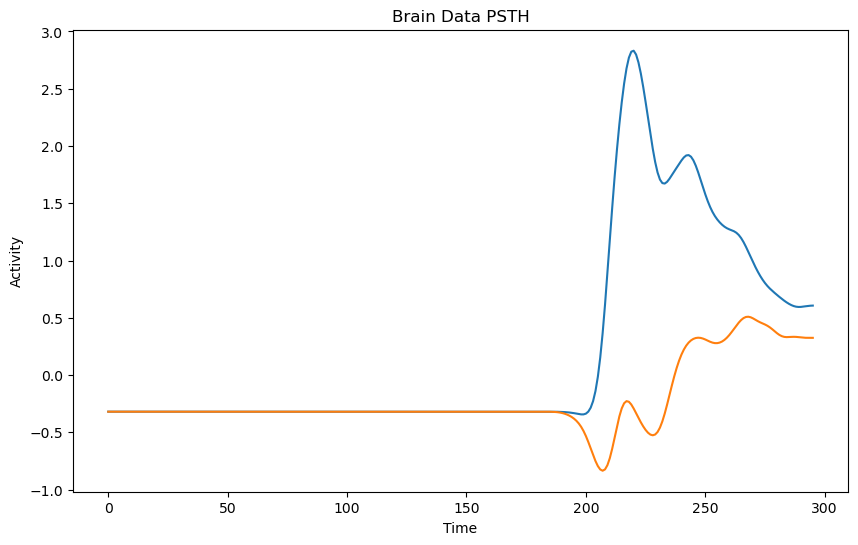

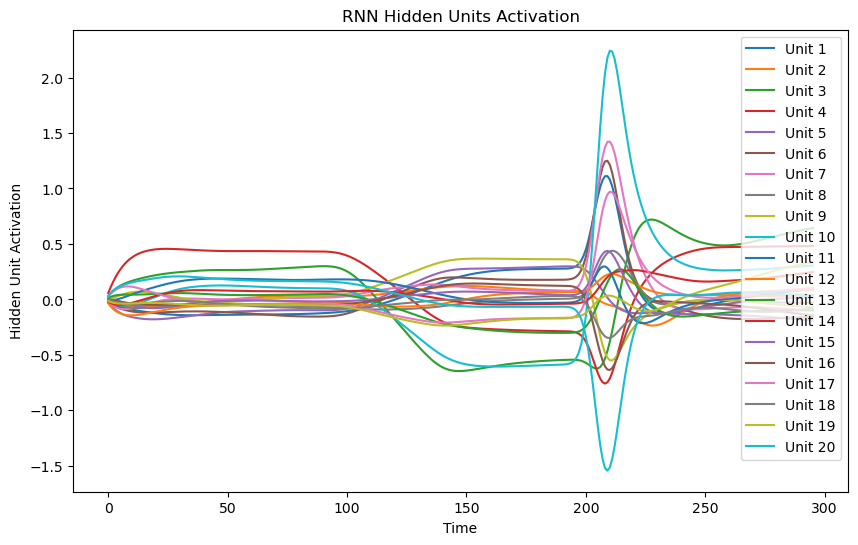

In [61]:
def plot_psth(data, title):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data
    :param title: a string for the plot title
    """
    # Mean across trials
    mean_data = data.mean(dim=0)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_data)
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title(title)
    plt.show()

# Plot PSTHs for brain data
plot_psth(normalized_muscle_tensor, "Brain Data PSTH")

def plot_rnn_psths(model, data_loader, title, max_time_steps, neurons=20):
    """
    Generate and plot PSTH-like plots for RNN hidden units.
    :param model: the RNN model
    :param data_loader: DataLoader containing input data
    :param title: a string for the plot title
    :param max_time_steps: maximum number of time steps in the sequences
    """
    model.eval()  # Set the model to evaluation mode
    model.to('cpu')
    
    with torch.no_grad():  # Disable gradient computations, since we don't need them during evaluation
        all_hidden_states = []  # List to collect hidden states from all batches

        for inputs, _ in data_loader:  # Iterate over batches
            h = model.init_hidden(inputs.size(0))  # Initialize the hidden state for this batch
            # Create an array to store hidden states for each time step of the current batch
            hidden_states = np.zeros((max_time_steps, h.shape[0], h.shape[1]))

            for t in range(inputs.shape[1]):  # Iterate over each time step
                _, h, _, _ = model(inputs[:, t, :], h)  # Forward pass for each time step, update hidden state
                hidden_states[t, :, :] = h.detach().numpy()  # Detach and store the hidden state

plt.figure(figsize=(15, 5))
for i in range(200):  # Iterate over five hidden units
    plt.plot(avg_hidden_states[:, i], label=f'Unit {i+1}')

        # Stack all hidden states and compute their mean across batches and time steps
        all_hidden_states_np = np.concatenate(all_hidden_states,0)
        avg_hidden_states = np.mean(all_hidden_states_np, axis=1)

        # Plot
        plt.figure(figsize=(10, 6))
        for i in range(min(neurons,avg_hidden_states.shape[1])):
            plt.plot(avg_hidden_states[:, i], label=f'Unit {i+1}')

        plt.xlabel('Time')
        plt.ylabel('Hidden Unit Activation')
        plt.title(title)
        plt.legend()
        plt.show()
        return all_hidden_states_np

# Determine the maximum number of time steps in your dataset
max_time_steps = max([inputs.shape[1] for inputs, _ in train_loader])

# Plot PSTH-like plots for RNN hidden units
all_hidden_states_np= plot_rnn_psths(model, train_loader, "RNN Hidden Units Activation", max_time_steps)

# Plot PSTH-like plots for RNN hidden units
# plot_rnn_psths(complicated_model, train_loader, "RNN Hidden Units Activation", max_time_steps)

In [ ]:
# Function to add gaussian noise to the input data.
def perturb_inputs(inputs, noise_level=0.1):
    # Generating noise with the same shape as inputs
    noise = torch.randn_like(inputs) * noise_level
    # Adding the generated noise to the inputs and returning the noisy inputs
    return inputs + noise

# Function to add noise to the weights of a neural network model
def perturb_weights(model, perturbation_factor=0.1):
    # Iterating over all parameters (weights and biases) of the model
    for param in model.parameters():
        # Checking if the parameter is trainable 
        if param.requires_grad:
            # Adding in-place Gaussian noise to the parameter
            param.data.add_(torch.randn_like(param) * perturbation_factor)

# Function to evaluate the model's performance on a dataset
def evaluate_model(model, data_loader, criterion, complicated=False):
    # Setting the model to evaluation mode
    model.eval()
    total_loss = 0.0
    # Disabling gradient calculation as it's not needed during evaluation
    with torch.no_grad():
        # Iterating through the dataset using the data loader
        for inputs, targets in data_loader:
            # Determining the batch size from the input shape
            batch_size = inputs.size(0)
            # Initializing the hidden state of the model for the current batch
            # Iterating over each time step in the input sequence
            for t in range(inputs.shape[1]):
                # Conditionally handling the model's forward pass based on the 'complicated' flag
                if complicated:
                    h = model.init_hidden()
                    # For a 'complicated' model, forward pass with the current timestep's input and hidden state.
                    output, h = model(inputs[:, t, :], h)
                else:
                    h = model.init_hidden(batch_size)
                    # For a simpler model, forward pass with additional unused outputs
                    output, h, _, _ = model(inputs[:, t, :], h)
                    # Calculating the loss between the model output and the target for the last timestep
                    loss = criterion(output, targets[:, -1, :])
                    # Accumulating the loss for the current batch
                    total_loss += loss.item()
                    # Returning the average loss across all batches in the data loader
                return total_loss / len(data_loader)
                
def assess_robustness(model, data_loader, criterion, perturb_function, perturbation_level, complicated=False):
    # Evaluate on non-perturbed data
    original_loss = evaluate_model(model, data_loader, criterion, complicated)
    # Perturb model
    perturb_function(model, perturbation_level)
    # Evaluate on perturbed data
    perturbed_loss = evaluate_model(model, data_loader, criterion, complicated)
    return original_loss, perturbed_loss

In [ ]:
# Evaluate and compare robustness
simple_original_loss, simple_perturbed_loss = assess_robustness(model, train_loader, criterion, perturb_weights, 0.1)
complex_original_loss, complex_perturbed_loss = assess_robustness(complicated_model, train_loader, criterion, perturb_weights, 0.1, complicated=True)

print(f"Simple Model - Original Loss: {simple_original_loss}, Perturbed Loss: {simple_perturbed_loss}")
print(f"Complex Model - Original Loss: {complex_original_loss}, Perturbed Loss: {complex_perturbed_loss}")


Simple Model - Original Loss: 0.055344562977552414, Perturbed Loss: 0.058175064623355865
Complex Model - Original Loss: 0.0, Perturbed Loss: 0.0
